In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("ALL.csv")

In [4]:
df.head(10)

,datetime,assetCode,month,week,alert,article,alert_relevance_weighted_sentiment,alert_relevance_weighted_negative_sentiment,alert_relevance_weighted_positive_sentiment,alert_relevance_weighted_neutral_sentiment,...,news_novelty_sum_12H,news_volume_sum_24H,news_novelty_sum_24H,news_volume_sum_3D,news_novelty_sum_3D,news_volume_sum_5D,news_novelty_sum_5D,news_volume_sum_7D,news_novelty_sum_7D,returnsOpenNextMktres10
0,2007-02-01,A.N,2,Thu,0,2,0.000000,0.014391,0.077904,0.907705,...,0.0,3.0,0.0,9.0,0.0,12.0,0.0,14.0,0.0,0.034672
1,2007-02-01,MRO.N,2,Thu,11,6,-0.448490,0.403749,0.261763,0.334488,...,27.0,145.0,27.0,531.0,81.0,621.0,81.0,621.0,81.0,-0.003119
2,2007-02-01,MS.N,2,Thu,0,5,0.616297,0.236554,0.545927,0.217519,...,1.0,52.0,1.0,138.0,1.0,152.0,1.0,203.0,1.0,-0.028923
3,2007-02-01,MSFT.O,2,Thu,0,9,0.296048,0.170371,0.485195,0.344435,...,0.0,100.0,0.0,499.0,0.0,593.0,0.0,1904.0,0.0,-0.059533
4,2007-02-01,MYL.N,2,Thu,12,5,1.000000,0.080555,0.574586,0.344859,...,49.0,517.0,64.0,616.0,74.0,616.0,74.0,616.0,74.0,0.002114
5,2007-02-01,NDAQ.O,2,Thu,0,8,-0.167655,0.259575,0.309139,0.431286,...,8.0,105.0,9.0,175.0,21.0,203.0,23.0,493.0,27.0,-0.075426
6,2007-02-01,NKE.N,2,Thu,0,7,0.950410,0.180625,0.605953,0.213422,...,3.0,21.0,3.0,68.0,3.0,91.0,3.0,91.0,3.0,0.036484
7,2007-02-01,NMX.N,2,Thu,4,2,1.000000,0.016599,0.717556,0.265846,...,5.0,60.0,5.0,140.0,22.0,140.0,22.0,140.0,22.0,0.024871
8,2007-02-01,NOC.N,2,Thu,1,3,1.000000,0.132907,0.593816,0.273277,...,3.0,27.0,3.0,67.0,3.0,67.0,3.0,188.0,3.0,0.041266
9,2007-02-01,MO.N,2,Thu,1,6,0.821637,0.077941,0.659008,0.263050,...,2.0,237.0,4.0,530.0,8.0,539.0,8.0,560.0,8.0,-0.016255


Testing factor alert
Sharpe ratio: -0.047840654248530144


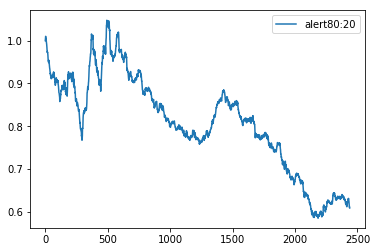

Testing factor article
Sharpe ratio: -0.03481577881386362


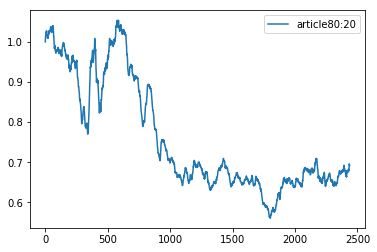

Testing factor alert_relevance_weighted_sentiment
Sharpe ratio: 0.06322476432230238


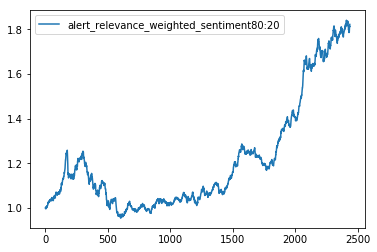

Testing factor alert_relevance_weighted_negative_sentiment
Sharpe ratio: -0.09484230161098314


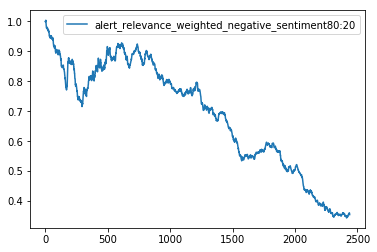

Testing factor alert_relevance_weighted_positive_sentiment
Sharpe ratio: 0.06704575329359781


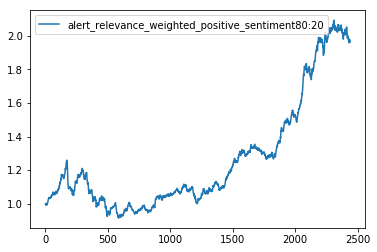

Testing factor alert_relevance_weighted_neutral_sentiment
Sharpe ratio: 0.044548771576794606


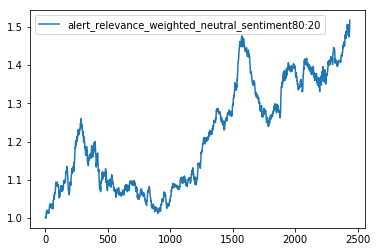

Testing factor alert_news_volume_sum_12H
Sharpe ratio: -0.04944699972782399


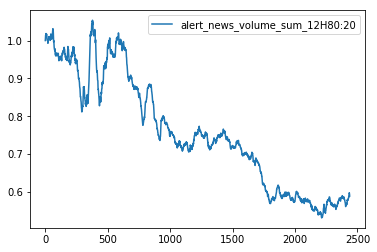

Testing factor alert_news_novelty_sum_12H
Sharpe ratio: -0.017263574286687716


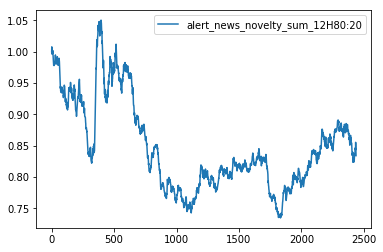

Testing factor alert_news_volume_sum_24H
Sharpe ratio: -0.04698487043644789


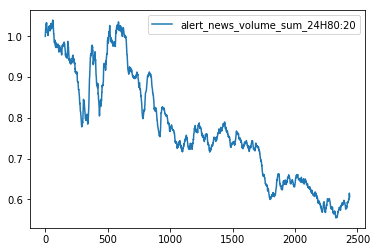

Testing factor alert_news_novelty_sum_24H
Sharpe ratio: -0.02225361013123965


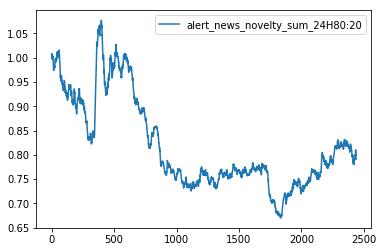

Testing factor alert_news_volume_sum_3D
Sharpe ratio: -0.04343404651095438


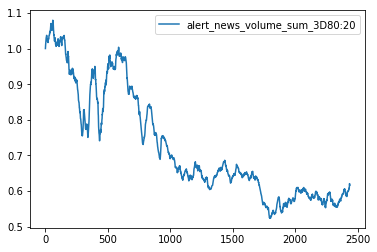

Testing factor alert_news_novelty_sum_3D
Sharpe ratio: -0.014806541976754488


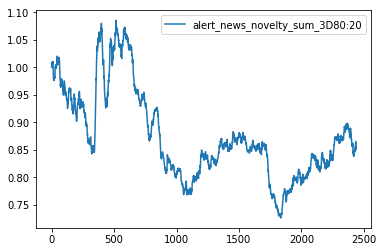

Testing factor alert_news_volume_sum_5D


In [ ]:
# orchesration function
def run_single_backtest(df):
    df = df[(df.returnsOpenNextMktres10 < 0.4) & (df.returnsOpenNextMktres10 > -0.4)]
    df = df.reset_index(drop=True)
    if 'universe' not in df.columns:
        df['universe'] = [1 for i in range(len(df))]
    assert('returnsOpenNextMktres10' in df.columns)
    count = 0
    count_list = []
    curr_date = df.datetime[0]
    for date in df.datetime:
        if date == curr_date:
            count+=1
        else:
            count_list.append(count)
            curr_date = date
            count = 1
    count_list.append(count)
    partition_rows = [0] + list(np.cumsum(count_list))
    exclude_list = ['assetCode', 'month', 'week', 'datetime', 'returnsOpenNextMktres10']
    for factor in df.columns:
        if factor not in exclude_list:
            print('Testing factor '+factor)
            single_factor_result = backtest_single_score( df, df[factor], partition_rows, count_list, offset = 60 )
            plot_returns(single_factor_result[0], factor)
            plt.show()

# Calculate the returns and Sharpe ratio of long-short portfolio for a single factor 
def backtest_single_score( df, score, partition_rows, count_list, num_group = 5, offset = 0 ):
    returns = []
    for i in range(offset,len(count_list)):
        l = partition_rows[i]
        r = partition_rows[i+1]
        stock_ret_i = df['returnsOpenNextMktres10'][l:r]
        score_i = score[l:r]
        index_i = np.argsort(score_i)+l
        tradeable_ret_i = stock_ret_i*df['universe'][l:r]
        # top 80 vs bottom 20
        port_ret_i = np.mean(tradeable_ret_i[index_i[-4*(r-l)//num_group:]])-np.mean(tradeable_ret_i[index_i[:4*(r-l)//num_group]])
        returns.append(port_ret_i)
    print("Sharpe ratio:",np.mean(returns)/np.std(returns))
    return returns,np.mean(returns)/np.std(returns)

# Assume we can realize 10-day return in one day and rebalance every day
# Use all the return data
def plot_returns ( returns, label=""):
    net_value = [1.0]
    for ret in returns:
        net_value.append(net_value[-1]*(1+ret))
    plt.plot(net_value, label = label+"80:20")
    plt.legend()

    
run_single_backtest(df)